In [1]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
import os
import cv2 as cv
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

[[174 173 173 ... 172 171 170]
 [176 172 173 ... 173 171 170]
 [174 173 172 ... 172 174 169]
 ...
 [177 177 177 ...  80  76  76]
 [176 176 176 ...  77  78  77]
 [174 172 171 ...  77  79  82]]


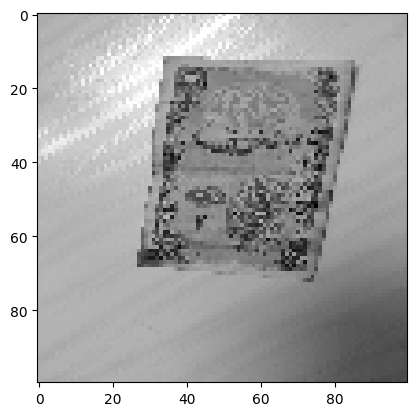

In [3]:
datadir = "/content/drive/MyDrive/AI_HW/VN_banknotes/data"
categories=['1000','10000','100000','2000','20000','200000','5000','50000','500000']
img_size=100
for category in categories:
  path=os.path.join(datadir,category)
  for img in os.listdir(path):
    img_array = cv.imread(os.path.join(path,img),cv.IMREAD_GRAYSCALE)
    new_array = cv.resize(img_array,(img_size,img_size))
    print(new_array)
    plt.imshow(new_array,cmap='gray')
    plt.show()
    break
  break

In [4]:
#Create training data:
training_data=[]
def create_traning_data():
  for category in categories:
    path = os.path.join(datadir,category)
    class_num = categories.index(category)

    for img in tqdm(os.listdir(path)):
      try:
        img_array =cv.imread(os.path.join(path,img),cv.IMREAD_GRAYSCALE)
        new_array = cv.resize(img_array,(img_size,img_size))
        training_data.append([new_array,class_num])
      except Exception as e:
        pass
create_traning_data()
print(len(training_data))

100%|██████████| 50/50 [00:16<00:00,  3.02it/s]

3383


In [5]:
#saving (x:features), (y:label)
x=[]
y=[]
for features, label in training_data :
 x.append(features)
 y.append(label)
x=np.array(x).reshape(-1,img_size,img_size,1)
y=np.array(y)
print('x',x.shape)
print('y',y.shape)

x (3383, 100, 100, 1)
y (3383,)


In [6]:
#saving x, y as file.pickle into drive
pickle_out = open("/content/drive/MyDrive/AI_HW/VN_banknotes/SAVE/x.pickle","wb")
pickle.dump(x, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/AI_HW/VN_banknotes/SAVE/y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [7]:
#BUILD MODEL
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Normalization, LeakyReLU
from keras.optimizers import Adam

In [8]:
pickle_in = open("/content/drive/MyDrive/AI_HW/VN_banknotes/SAVE/x.pickle","rb")
x_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/AI_HW/VN_banknotes/SAVE/y.pickle","rb")
y_train = pickle.load(pickle_in)

In [9]:
x_train=x_train/255.0
print('X train',x_train.shape)

X train (3383, 100, 100, 1)


In [12]:
from keras.utils import to_categorical #ONE HOT ENCODING
y_train= to_categorical(y,9)
print('Y train',y_train.shape)

Y train (3383, 9)


In [13]:
model=Sequential()

#layer
model.add(Conv2D(32,kernel_size = (3,3), activation = 'relu',
                 input_shape = (100,100,1),
                 padding = 'same'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D((2,2),padding = 'same'))
model.add(Dropout(0.1))

#layer
model.add(Conv2D(64,(3,3), activation = 'relu',
                 padding = 'same'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D((2,2),padding = 'same'))
model.add(Dropout(0.1))

#layer
model.add(Conv2D(128,(3,3), activation = 'relu',
                 padding = 'same'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D((2,2),padding = 'same'))
model.add(Dropout(0.1))

#ANN
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(LeakyReLU(alpha = 0.1))
model.add(Dense(9, activation = 'softmax'))

from keras.losses import categorical_crossentropy
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(),
              metrics = ['accuracy'])
model.summary()
history = model.fit(x_train, y_train, batch_size = 64, epochs = 30, verbose = 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 100, 100, 32)      320       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 50, 50, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 50, 50, 64)        0         
                                                      

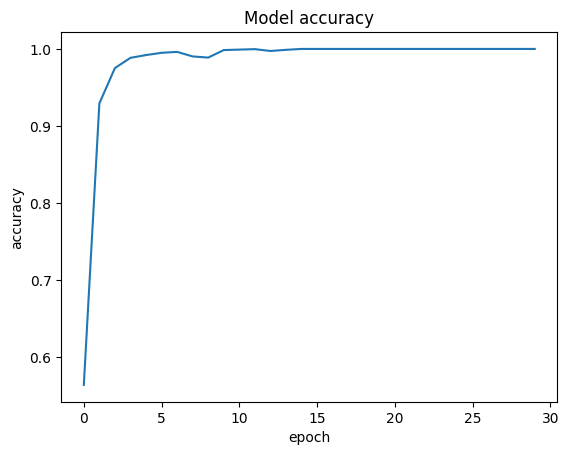

In [14]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [15]:
model.save('VN_banknotes.h5')

In [16]:
from keras.models import load_model
from keras.utils import load_img,img_to_array
from skimage import color
from skimage import io

In [17]:
model_banknotes = load_model('/content/drive/MyDrive/AI_HW/VN_banknotes/SAVE/VN_banknotes.h5')

In [18]:
# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(100, 100))
    return img

labels = {0:'1,000',
          1:'10,000',
          2:'100,000',
          3:'2,000',
          4:'20,000',
          5:'200,000',
          6:'5,000',
          7:'50,000',
          8:'500,000'}

1/1 [==============================] - 0s 26ms/step
[[0. 0. 0. 0. 0. 0. 1. 0. 0.]]
expectation: 5,000


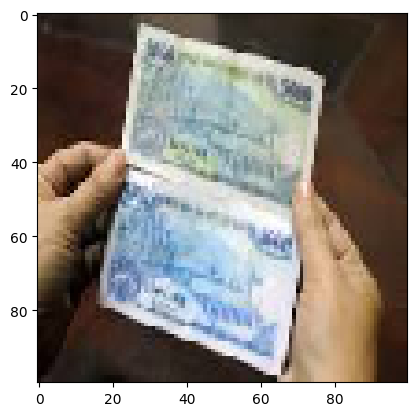

In [27]:
#load img and test:
img = load_image('/content/drive/MyDrive/AI_HW/test_all/banknotes/5k.jpg')
plt.imshow(img)
img = img_to_array(img)
img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
img = img.reshape(1,100,100,1)
result = model_banknotes.predict(img)
print(result)
np.argmax(result)
print('expectation:',labels[np.argmax(result)])

1/1 [==============================] - 0s 27ms/step
[[0. 0. 0. 0. 0. 1. 0. 0. 0.]]
expectation: 200,000


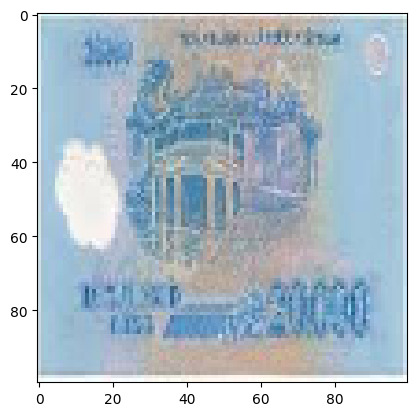

In [20]:
#load img and test:
img = load_image('/content/drive/MyDrive/AI_HW/test_all/banknotes/20k_1.jpg')
plt.imshow(img)
img = img_to_array(img)
img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
img = img.reshape(1,100,100,1)
result = model_banknotes.predict(img)
print(result)
np.argmax(result)
print('expectation:',labels[np.argmax(result)])

1/1 [==============================] - 0s 18ms/step
[[0. 0. 0. 0. 0. 1. 0. 0. 0.]]
expectation: 200,000


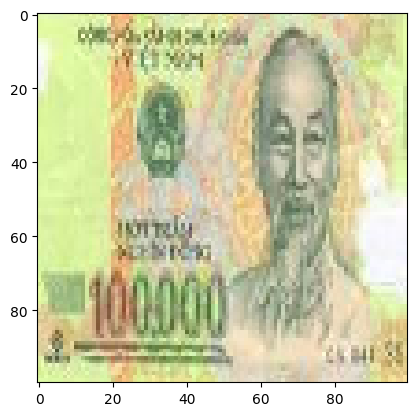

In [24]:
#load img and test:
img = load_image('/content/drive/MyDrive/AI_HW/test_all/banknotes/100k_1.jpg')
plt.imshow(img)
img = img_to_array(img)
img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
img = img.reshape(1,100,100,1)
result = model_banknotes.predict(img)
print(result)
np.argmax(result)
print('expectation:',labels[np.argmax(result)])